# Btc Moving Average Trade Strategy

## Download and process the data

In [1]:
import json
import time
import sys
from datetime import datetime
from urllib.request import Request, urlopen
from urllib.parse import urlencode
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import math as ma

minute = 60
hour = minute*60
day = hour*24
week = day*7
month = day*30
year = day*365

# Possible Commands
PUBLIC_COMMANDS = [ 'returnTradeHistory', 'returnChartData','returnLoanOrders']

class Poloniex:
    def __init__(self):
        # Conversions
        self.timestamp_str = lambda timestamp=time.time(), format="%Y-%m-%d %H:%M:%S": datetime.fromtimestamp(timestamp).strftime(format)
        self.str_timestamp = lambda datestr=self.timestamp_str(), format="%Y-%m-%d %H:%M:%S": int(time.mktime(time.strptime(datestr, format)))
        self.float_roundPercent = lambda floatN, decimalP=2: str(round(float(floatN) * 100, decimalP))+"%"

        # PUBLIC COMMANDS
        
        self.marketChart = lambda pair, period, start=time.time()-(month*1), end=time.time(): self.api('returnChartData', {'currencyPair':pair, 'period':period, 'start':start, 'end':end})
        self.marketTradeHist = lambda pair, start=time.time()-(day*2), end=time.time(): self.api('returnTradeHistory',{'currencyPair':pair, 'start':start, 'end':end}) # NEEDS TO BE FIXED ON Poloniex
        self.marketLoans = lambda coin: self.api('returnLoanOrders',{'currency':coin})
        
    #####################
    # Main Api Function #
    #####################
    def api(self, command, args={}):
        """
        returns 'False' if invalid command or if no APIKey or Secret is specified (if command is "private")
        returns {"error":"<error message>"} if API error
        """
        if command in PUBLIC_COMMANDS:
            url = 'https://poloniex.com/public?'
            args['command'] = command
            ret = urlopen(Request(url + urlencode(args)))
            return json.loads(ret.read().decode(encoding='UTF-8'))
        else:
            return False


In [3]:
Pol = Poloniex()
pair = 'USDT_BTC'
period = 300
MarketChart = pd.DataFrame(Pol.marketChart(pair, period))
for i in MarketChart.index:
    
    MarketChart.loc[i, 'date_str'] = Pol.timestamp_str(MarketChart.loc[i, 'date'])
MarketChart[ 'date_str'] =  pd.DatetimeIndex(MarketChart['date_str'])
MarketChart.set_index(keys = 'date_str', inplace = True)

In [18]:
MarketChart.head()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
date_str,,,,,,,,
2019-04-01 09:15:57,4130.318509,1554081357,4130.318509,4130.318509,4130.318509,0.000000,0.000000,4130.318509
2019-04-01 09:20:00,4122.456512,1554081600,4130.318509,4122.456512,4130.318509,0.421827,1740.165971,4125.304878
2019-04-01 09:25:00,4122.910000,1554081900,4122.910000,4122.910000,4122.910000,0.043845,180.769896,4122.910000
2019-04-01 09:30:00,4123.500000,1554082200,4125.073123,4123.500000,4125.012460,0.927276,3823.631369,4123.511473
2019-04-01 09:35:00,4124.514492,1554082500,4124.514492,4121.595999,4122.156512,2.682758,11057.577211,4121.720672


In [5]:
MarketTradeHist = pd.DataFrame(Pol.marketTradeHist(pair))
MarketTradeHist[ 'date'] =  pd.DatetimeIndex(MarketTradeHist['date'])
MarketTradeHist.set_index(keys = 'date', inplace = True)
MarketTradeHist = MarketTradeHist.sort_index()
MarketTradeHist.rename(columns = {'rate':'trade_price'}, inplace = True)
MarketTradeHist.rename(columns = {'amount':'trade_qty'}, inplace = True)

In [55]:
MarketTradeHist.head()

,trade_qty,globalTradeID,orderNumber,trade_price,total,tradeID,type
date,,,,,,,
2019-04-29 07:26:40,0.00741216,414999823,259965449446,5318.42340452,39.42100522,26740799,buy
2019-04-29 07:28:34,2.00000000,414999908,259965541354,5318.42340452,10636.84680904,26740800,buy
2019-04-29 07:33:24,0.04972542,415000078,259966266628,5318.99010000,264.48901669,26740802,buy
2019-04-29 07:33:24,0.05879492,415000077,259966266628,5318.99009999,312.72959740,26740801,buy
2019-04-29 07:38:37,0.00173684,415000248,259966508386,5318.99010002,9.23823476,26740804,sell


In [49]:
MarketTradeHist.tail()

,amount,globalTradeID,orderNumber,rate,total,tradeID,type
date,,,,,,,
2019-05-01 07:17:09,0.04430340,415148854,260495423941,5351.74915118,237.10068334,26748575,buy
2019-05-01 07:17:14,0.01294777,415148855,260495428936,5351.74915118,69.29321710,26748576,buy
2019-05-01 07:17:14,0.03781040,415148857,260495429935,5351.74915118,202.35177610,26748577,buy
2019-05-01 07:17:16,0.01531140,415148858,260495437927,5351.74915118,81.94277195,26748578,buy
2019-05-01 07:17:16,0.03759900,415148859,260495440924,5351.74915118,201.22041633,26748579,buy


In [7]:
MarketLoans = Pol.marketLoans('BTC')

In [9]:
MarketLoans_offers = pd.DataFrame(MarketLoans['offers'])

In [53]:
MarketLoans_offers.head()

,amount,rangeMax,rangeMin,rate
0,16.28882113,2,2,0.00009000
1,2.43271514,2,2,0.00009001
2,2.40020342,2,2,0.00009002
3,0.12169494,2,2,0.00009003
4,0.00501910,2,2,0.00009004


In [11]:
MarketLoans_demands = pd.DataFrame(MarketLoans['demands'])

In [14]:
MarketLoans_demands

,amount,rangeMax,rangeMin,rate
0,0.01730744,2,2,0.02000000
1,0.02012086,2,2,0.00001000
2,2.05450566,2,2,0.00000100


In [143]:
MarketTradeHist['trade_qty'] = MarketTradeHist['trade_qty'].astype('float')
MarketTradeHist['trade_price'] = MarketTradeHist['trade_price'].astype('float')

In [268]:
trade_start_hour1 = random.randint(8, 19)

In [269]:
start_time = '2019-04-29' + ' ' + str(trade_start_hour) + ':00:00'
end_time = '2019-04-29' + ' ' + str(trade_start_hour + 4) + ':00:00'

In [270]:
daytrades1 = MarketTradeHist[start_time: end_time]

In [275]:
trade_start_hour2 = random.randint(8, 19)

In [307]:
start_time = '2019-04-30' + ' ' + str(trade_start_hour2) + ':00:00'
end_time = '2019-04-30' + ' ' + str(trade_start_hour2 + 4) + ':00:00'
daytrades2 = MarketTradeHist[start_time: end_time]

In [271]:
daytrades1.head()

,trade_qty,globalTradeID,orderNumber,trade_price,total,tradeID,type
date,,,,,,,
2019-04-29 16:00:03,0.074564,415033526,260054428378,5244.7000,391.06376536,26743164,sell
2019-04-29 16:00:10,0.029800,415033531,260054466340,5244.7000,156.29206000,26743165,sell
2019-04-29 16:00:12,0.081994,415033533,260054475331,5244.7000,430.03178147,26743166,sell
2019-04-29 16:01:01,0.000382,415033579,260054673133,5239.4553,2.00000487,26743167,sell
2019-04-29 16:01:46,0.002493,415033640,260054824981,5239.4553,13.06059980,26743168,buy


In [308]:
daytrades2.head()

,trade_qty,globalTradeID,orderNumber,trade_price,total,tradeID,type
date,,,,,,,
2019-04-30 10:00:49,1.051452,415081291,260253620986,5224.0,5492.78352408,26744915,buy
2019-04-30 10:01:51,0.086141,415081373,260253786820,5224.0,449.99995712,26744916,buy
2019-04-30 10:01:53,0.001093,415081377,260253787819,5224.0,5.71051112,26744917,buy
2019-04-30 10:01:55,0.900000,415081379,260253792814,5224.0,4701.60000000,26744918,buy
2019-04-30 10:03:28,0.000879,415081578,260253940666,5224.0,4.58928400,26744919,buy


## calculate the trading related cost

In [231]:
%matplotlib inline
from scipy.ndimage.interpolation import shift
import time
import datetime
from sklearn import linear_model as linear_model
matplotlib.rcParams[ 'figure.figsize' ] = ( 14, 6 )
from pandas.plotting import register_matplotlib_converters
import random
register_matplotlib_converters()
def show_time( label_string ):
    ts = time.time()
    st = datetime.datetime.fromtimestamp( ts ).strftime( '%Y-%m-%d %H:%M:%S:%f' )
    print( label_string + ' : ' + st )

### train VWAP Algo with train data

In [278]:

# now let's make some 1 minute data using resample
minute_data = pd.DataFrame()
minute_data['open'] = daytrades1['trade_price'].resample('Min').first()
minute_data['close'] = daytrades1['trade_price'].resample('Min').last()
minute_data['high'] = daytrades1['trade_price'].resample('Min').max()
minute_data['low'] = daytrades1['trade_price'].resample('Min').min()
minute_data['volume'] = daytrades1['trade_qty'].resample('Min').sum()

In [279]:
for index , row in minute_data.iterrows():
    if np.isnan(minute_data.loc[index, 'open']):
        minute_data.loc[index, 'open'] =  minute_data.loc[index - 1, 'open']
        minute_data.loc[index, 'close'] =  minute_data.loc[index - 1, 'close']
        minute_data.loc[index, 'high'] =  minute_data.loc[index - 1, 'high']
        minute_data.loc[index, 'low'] =  minute_data.loc[index - 1, 'low']
        minute_data.loc[index, 'volume'] =  0.0

In [280]:
minute_data.head()

,open,close,high,low,volume
date,,,,,
2019-04-29 16:00:00,5244.700000,5244.700000,5244.700000,5244.700000,0.186357
2019-04-29 16:01:00,5239.455300,5239.455300,5239.455300,5239.455300,0.409966
2019-04-29 16:02:00,5247.971940,5247.971940,5247.978098,5247.971940,0.424993
2019-04-29 16:03:00,5247.978098,5244.927344,5247.978098,5244.927344,0.420796
2019-04-29 16:04:00,5248.726114,5248.726114,5248.726114,5248.726114,0.000320


In [281]:
# calculate the cumulative pct by day
minute_data[ 'accum_volume' ] = minute_data.groupby( [ minute_data.index.date ] ).cumsum()[ 'volume' ] 
minute_data[ 'accum_pct' ] = minute_data.groupby( [ minute_data.index.date ] )[ 'accum_volume' ].transform( lambda x: x / x.iloc[ -1 ] )

In [282]:
minute_data.head()

,open,close,high,low,volume,accum_volume,accum_pct
date,,,,,,,
2019-04-29 16:00:00,5244.700000,5244.700000,5244.700000,5244.700000,0.186357,0.186357,0.006531
2019-04-29 16:01:00,5239.455300,5239.455300,5239.455300,5239.455300,0.409966,0.596323,0.020900
2019-04-29 16:02:00,5247.971940,5247.971940,5247.978098,5247.971940,0.424993,1.021317,0.035795
2019-04-29 16:03:00,5247.978098,5244.927344,5247.978098,5244.927344,0.420796,1.442113,0.050543
2019-04-29 16:04:00,5248.726114,5248.726114,5248.726114,5248.726114,0.000320,1.442433,0.050554


In [283]:
len(minute_data)

240

In [284]:
# add a minute bin
# US start of date, calc in minutes
start_of_day = 8 * 60 
# get the time for each bin in minutes and subtract 9:30
minute_data[ 'minute_bars' ] = ( minute_data.index.hour * 60 ) + minute_data.index.minute - start_of_day

In [285]:
# arrange our data
minute_bars = minute_data[ 'minute_bars' ]
X = pd.DataFrame( { 'bin': minute_bars, 
                    'bin2' : minute_bars**2, 
                    'bin3' : minute_bars**3, 
                    'bin4' : minute_bars**4, 
                    'bin5' : minute_bars**5 } )
y = minute_data[ 'accum_pct' ]

In [286]:
len(y)

240

In [287]:
# now do the regression
lm = linear_model.LinearRegression()
model = lm.fit( X, y )
predictions = lm.predict( X )
# Rsquared
lm.score( X, y )

0.9319208713030841

In [288]:
# do we have any null values?
y[y.isnull()]

Series([], Freq: T, Name: accum_pct, dtype: float64)

In [289]:
# coefficients
lm.coef_

array([ 2.01200000e-06,  5.95971055e-04, -2.26216136e-06,  3.17753678e-09,
       -1.55986084e-12])

In [290]:
lm.intercept_

-15.839768930313925

In [291]:
# now do the regression with no intercept
lm2 = linear_model.LinearRegression( fit_intercept = False )
model = lm2.fit( X, y )
predictions = lm2.predict( X )

# Rsquared
lm2.score( X, y )

0.9317054832253564

In [292]:
lm2.coef_

array([-1.17900603e-01,  9.38900945e-04, -2.74658965e-06,  3.50686480e-09,
       -1.64468714e-12])

In [293]:
lm2.intercept_

0.0

In [294]:
predictions[- 1]

0.8864934310033166

<function matplotlib.pyplot.show(*args, **kw)>

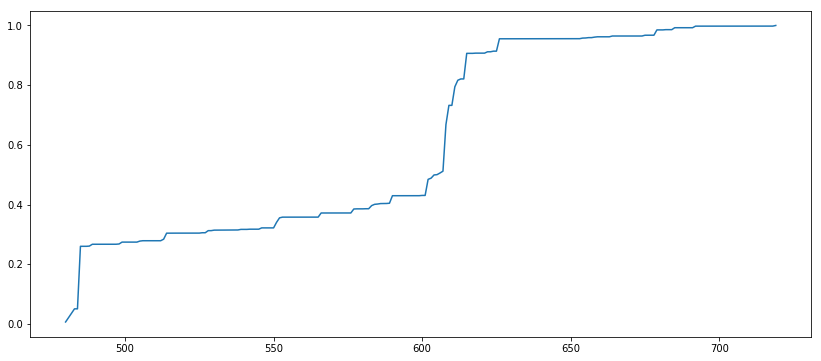

In [295]:
plt.plot(minute_data['minute_bars'], minute_data[ 'accum_pct' ])
plt.show

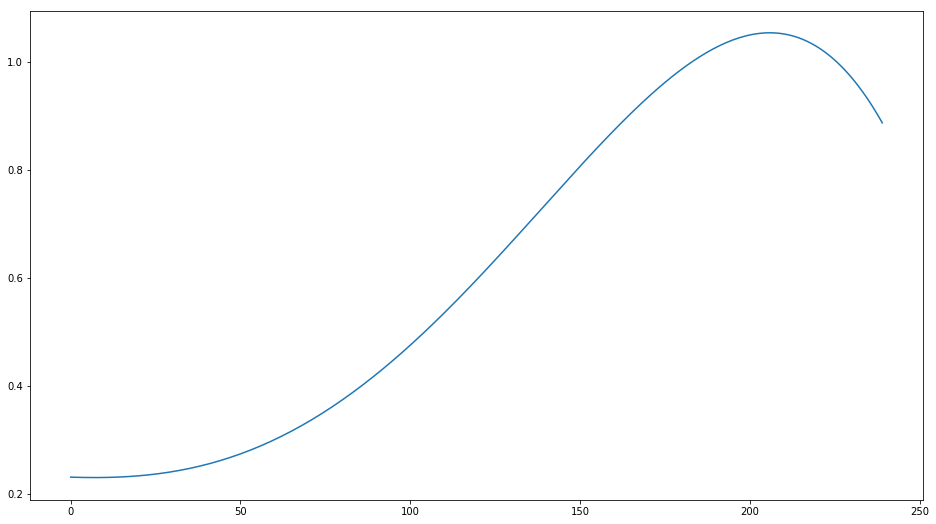

In [296]:
fig, ax1 = plt.subplots(figsize=(16,9))
plt.plot(predictions)

In [297]:
# or is there something about this that keeps it from getting to 1.0 that I'm forgetting?
minute_data.index

DatetimeIndex(['2019-04-29 16:00:00', '2019-04-29 16:01:00',
               '2019-04-29 16:02:00', '2019-04-29 16:03:00',
               '2019-04-29 16:04:00', '2019-04-29 16:05:00',
               '2019-04-29 16:06:00', '2019-04-29 16:07:00',
               '2019-04-29 16:08:00', '2019-04-29 16:09:00',
               ...
               '2019-04-29 19:50:00', '2019-04-29 19:51:00',
               '2019-04-29 19:52:00', '2019-04-29 19:53:00',
               '2019-04-29 19:54:00', '2019-04-29 19:55:00',
               '2019-04-29 19:56:00', '2019-04-29 19:57:00',
               '2019-04-29 19:58:00', '2019-04-29 19:59:00'],
              dtype='datetime64[ns]', name='date', length=240, freq='T')

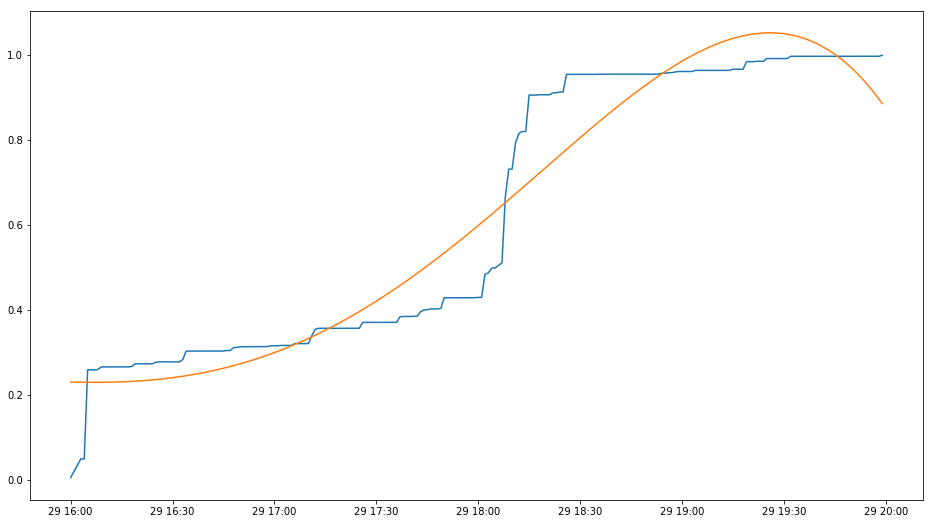

In [298]:
tgt_date = '2019-04-29'
fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )
ax1.plot( minute_data[ 'accum_pct' ] )
tgtsSeries = pd.Series( predictions )
tgtsSeries.index = minute_data.index
ax1.plot( tgtsSeries )
plt.show()

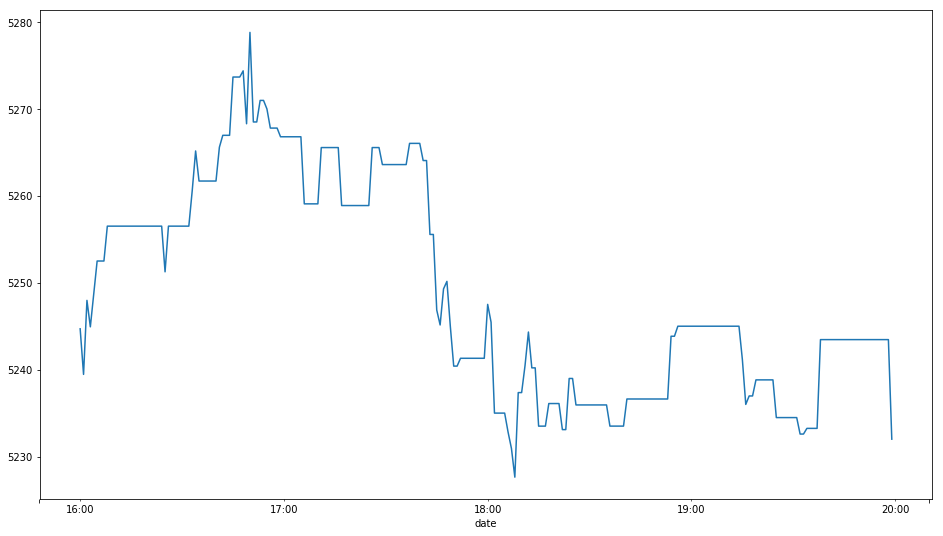

In [299]:
minute_data['close'].plot(figsize=(16,9))

### run a VWAP Algo with test data

In [300]:
# returns next minute target
# scale the last value to ensure it converges to 1 by the end and then shift the series by back by one
def get_vwap_targets( order_size ):
    bar_pcts = predictions
    bar_pcts = bar_pcts / predictions[ -1]
    bar_pcts = shift( bar_pcts, -1, cval=1 )
    return np.minimum( ( bar_pcts * order_size ).astype( 'float' ), order_size )

In [301]:
order_quantity = 5

In [302]:
# generate target schedule - use bins 1 - 390 giving an automatic 1 minute "look ahead"
# note that targets have been converted to shares from percent
order_targets = get_vwap_targets( order_quantity )

In [303]:
order_targets[190:240]

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [306]:
trade_start_hour2

10

start loop : 2019-05-01 21:32:36:257774
end loop : 2019-05-01 21:32:36:443833
Btc volume: 159.80253439999916
order shares traded: 5.0
average price: 5260.759565576882
%trading_related_cost:0.7%
average trade size: 0.06944444444444445


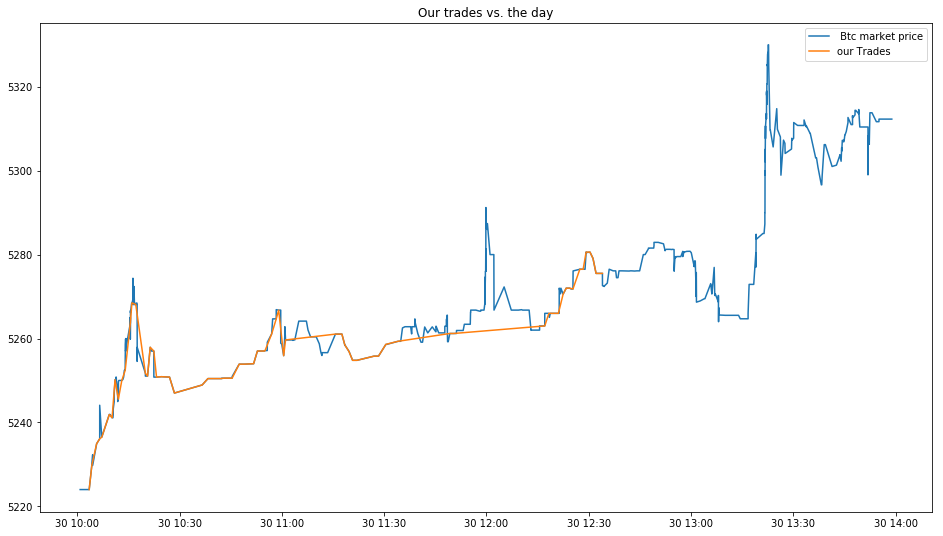

In [314]:
# initialize some other variables
current_bar = 1
current_target = 0
quantity_filled = 0
last_price = 0.0
last_quantity = 0.0
total_volume = 0.0
vwap_numerator = 0.0
trades_arr = []
average_trades_price = 0
n = 1
trades_amount = 0
quantity_remaining = order_quantity
quantity_filled = 0
trading_related_cost = 0
# main event loop
show_time( 'start loop' )
for index, row in daytrades2.iterrows():
    # figure out which minute we are in after the open
    time_from_open = ( index - pd.Timedelta( hours = trade_start_hour2, minutes = 0 ) )
    minutes_from_open = ( time_from_open.hour * 60 ) + time_from_open.minute
        
    last_price = row[ 'trade_price' ]
    last_quantity = row[ 'trade_qty' ]
        
    # collect volume
    total_volume += last_quantity
   
    # are we in a new minute?
    if ( minutes_from_open > current_bar ):
        # we're in a new bar do new bar things here
        current_bar = minutes_from_open
        current_target = min( np.ceil( order_targets[ current_bar ] ), order_quantity )
        # trade logic
        quantity_behind = current_target - quantity_filled
        if ( quantity_behind > 0 ): # we need to trade now
            new_trade_price = last_price
            new_trade_quantity = min(quantity_behind, last_quantity)
            trades_arr.append( ( new_trade_price, new_trade_quantity, current_bar, index ) )
            
            # update quantity remaining
            quantity_remaining = min( 0, quantity_remaining - new_trade_quantity )
            quantity_filled += new_trade_quantity
            arrival_price = trades_arr[0][0]
            trading_related_cost += new_trade_quantity * (new_trade_price - arrival_price)
        
# looping done
show_time( 'end loop' )
#Now, let's look at some stats
        
trades_df = pd.DataFrame( trades_arr, columns=[ 'trade_price', 'trade_qty', 'bar', 'time' ] )
trades_df.index = pd.to_datetime( trades_df[ 'time' ] )
trades_df = trades_df.drop( columns = ['time'] )
print( 'Btc volume: ' + str( total_volume ) )
print( 'order shares traded: ' + str( quantity_filled ) )
avg_price = (trades_df[ 'trade_price' ] * trades_df[ 'trade_qty' ]).sum() / trades_df[ 'trade_qty' ].sum()
trading_related_cost_pct = round(trading_related_cost / (order_quantity * arrival_price) * 100, 2)
print( 'average price: ' + str( avg_price ) )
print('%trading_related_cost:' + str(trading_related_cost_pct) + '%')
print( 'average trade size: ' + str( trades_df[ 'trade_qty' ].mean() ) )
fig, ax1 = plt.subplots( figsize = ( 16, 9 ) )
ax1.plot( daytrades2[ 'trade_price' ], label = ' Btc market price' )
ax1.plot( trades_df[ 'trade_price' ], label = 'our Trades' )
plt.title( 'Our trades vs. the day' )
plt.legend()
plt.show()



In [318]:
trading_fee_pct = 0.2
trading_cost_pct = trading_fee_pct + trading_related_cost_pct

## Moving Average Trade Strategy

### calculate EMA

In [17]:

ema = []
for j in range(1, 20):
    ema.append(MarketChart['close'].ewm(span = 10 * j).mean())


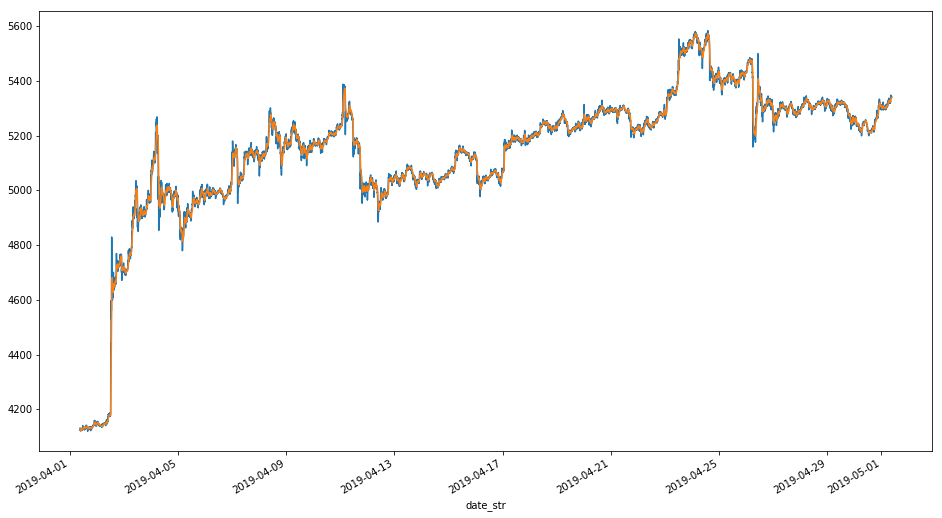

In [41]:
MarketChart['close'].plot(figsize=(16,9))
plt.plot(MarketChart.index, ema[0])
plt.show()

### calculate the difference pecentage between close and ema

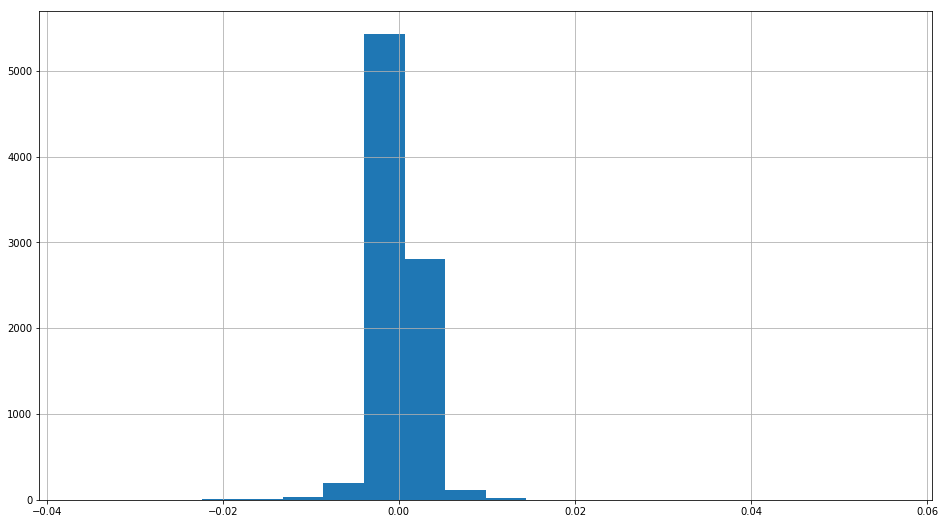

j=0 diff_pct_close_vs_ema_negative_unnormal: -0.008 diff_pct_close_vs_ema_min: -0.036 diff_pct_close_vs_ema_max:0.056 diff_pct_close_vs_ema_positive_unnormal: 0.009


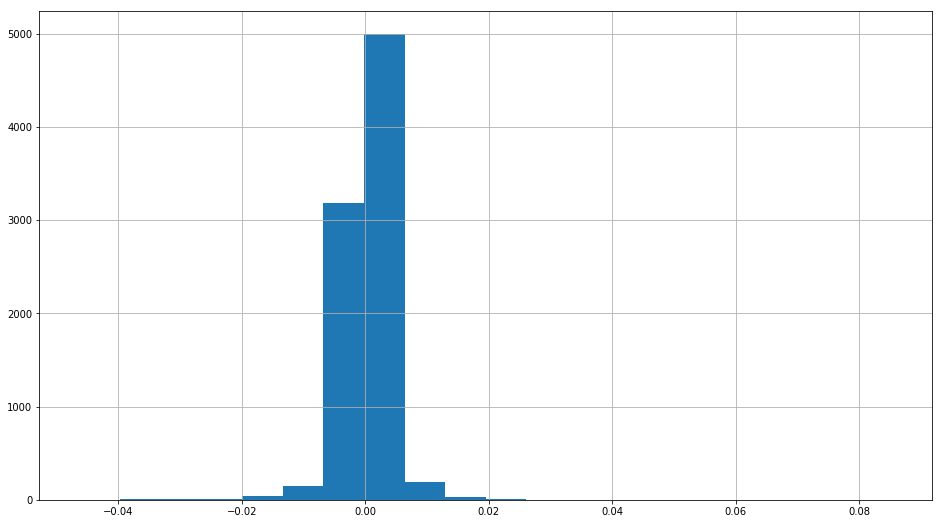

j=1 diff_pct_close_vs_ema_negative_unnormal: -0.012 diff_pct_close_vs_ema_min: -0.046 diff_pct_close_vs_ema_max:0.085 diff_pct_close_vs_ema_positive_unnormal: 0.013


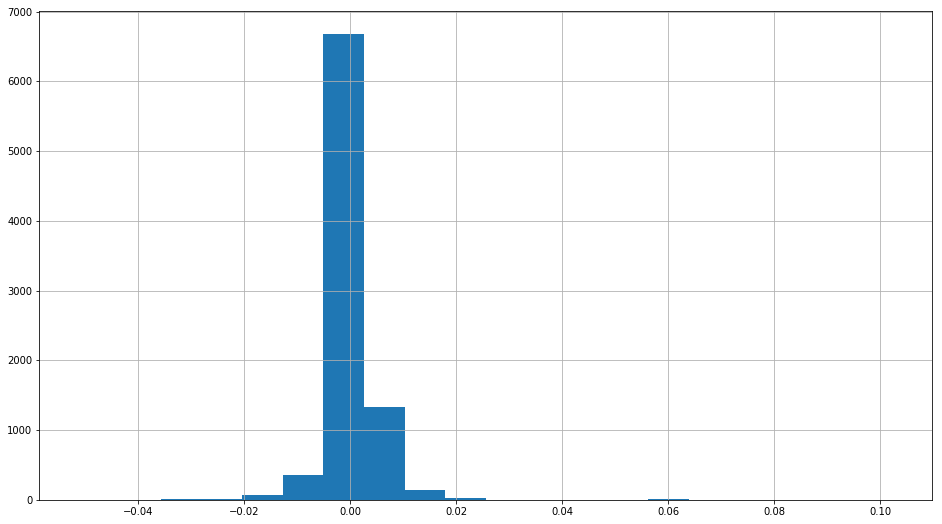

j=2 diff_pct_close_vs_ema_negative_unnormal: -0.015 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.102 diff_pct_close_vs_ema_positive_unnormal: 0.016


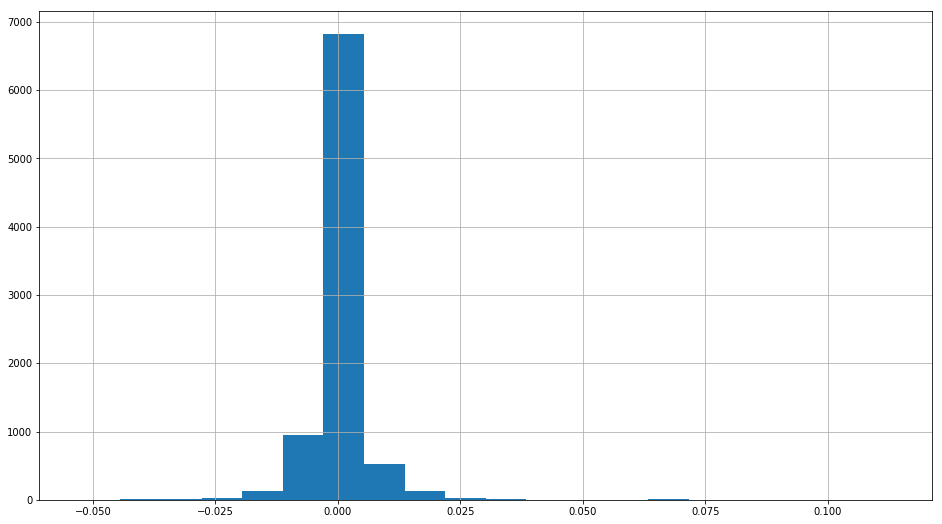

j=3 diff_pct_close_vs_ema_negative_unnormal: -0.017 diff_pct_close_vs_ema_min: -0.053 diff_pct_close_vs_ema_max:0.113 diff_pct_close_vs_ema_positive_unnormal: 0.019


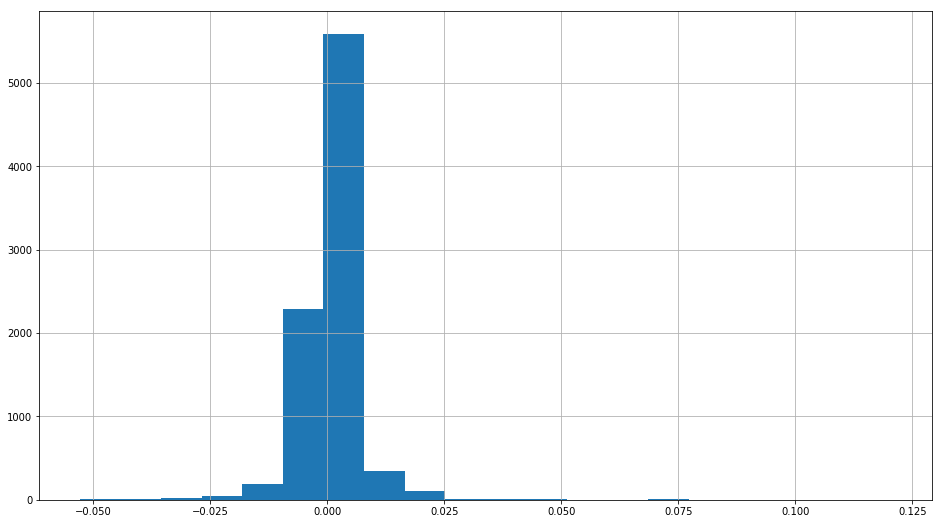

j=4 diff_pct_close_vs_ema_negative_unnormal: -0.019 diff_pct_close_vs_ema_min: -0.053 diff_pct_close_vs_ema_max:0.121 diff_pct_close_vs_ema_positive_unnormal: 0.021


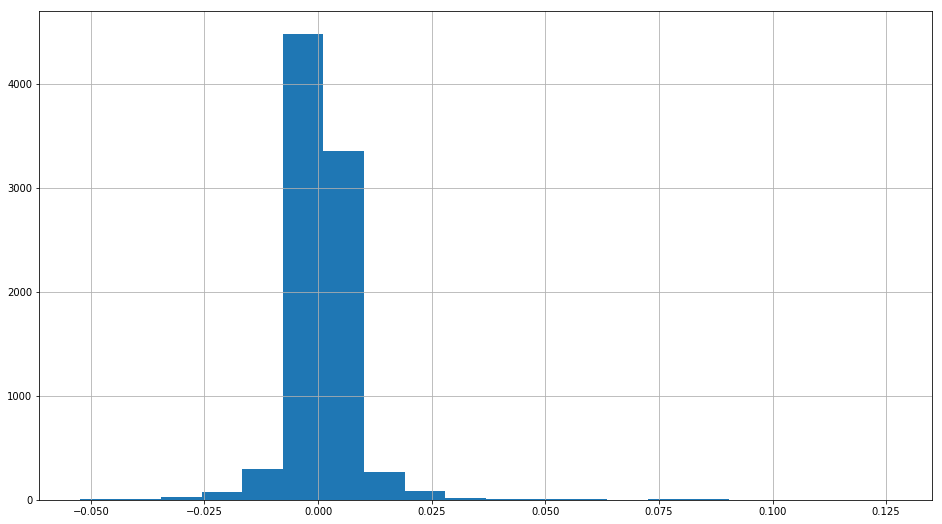

j=5 diff_pct_close_vs_ema_negative_unnormal: -0.021 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.126 diff_pct_close_vs_ema_positive_unnormal: 0.023


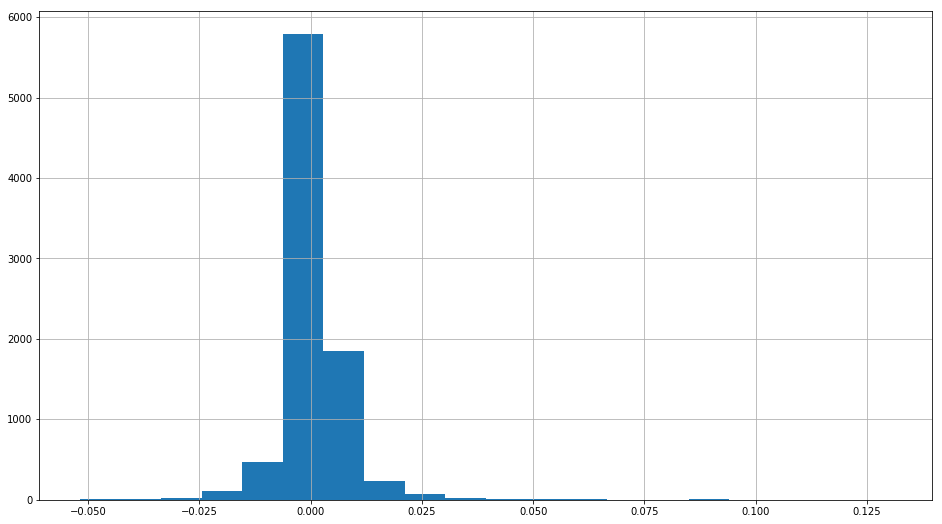

j=6 diff_pct_close_vs_ema_negative_unnormal: -0.023 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.131 diff_pct_close_vs_ema_positive_unnormal: 0.025


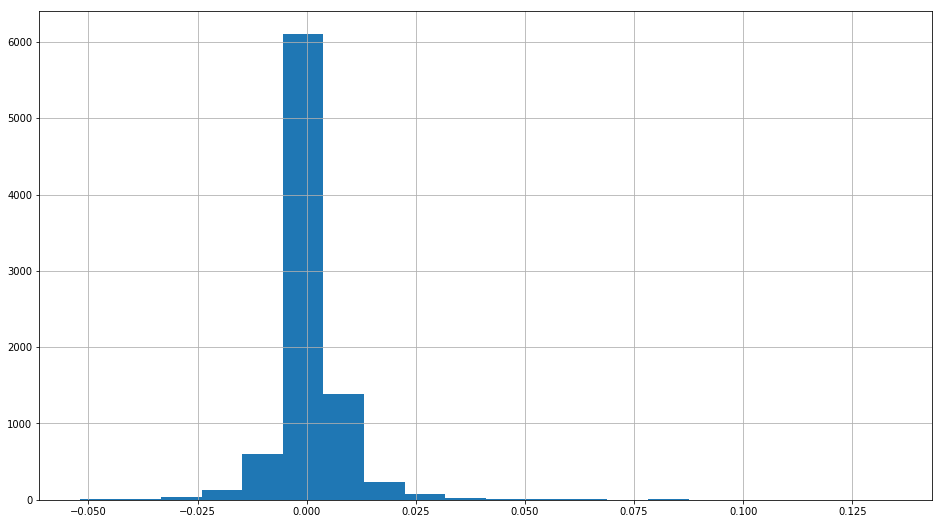

j=7 diff_pct_close_vs_ema_negative_unnormal: -0.024 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.134 diff_pct_close_vs_ema_positive_unnormal: 0.026


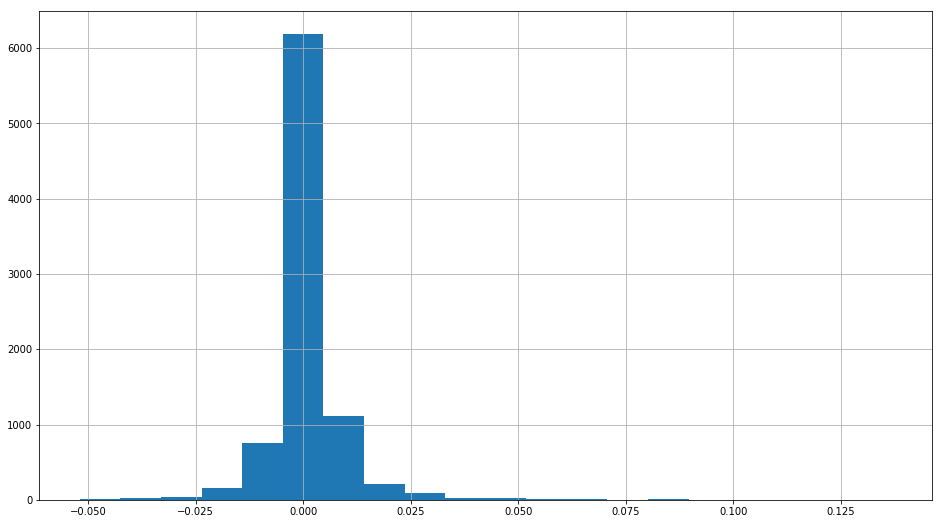

j=8 diff_pct_close_vs_ema_negative_unnormal: -0.025 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.137 diff_pct_close_vs_ema_positive_unnormal: 0.028


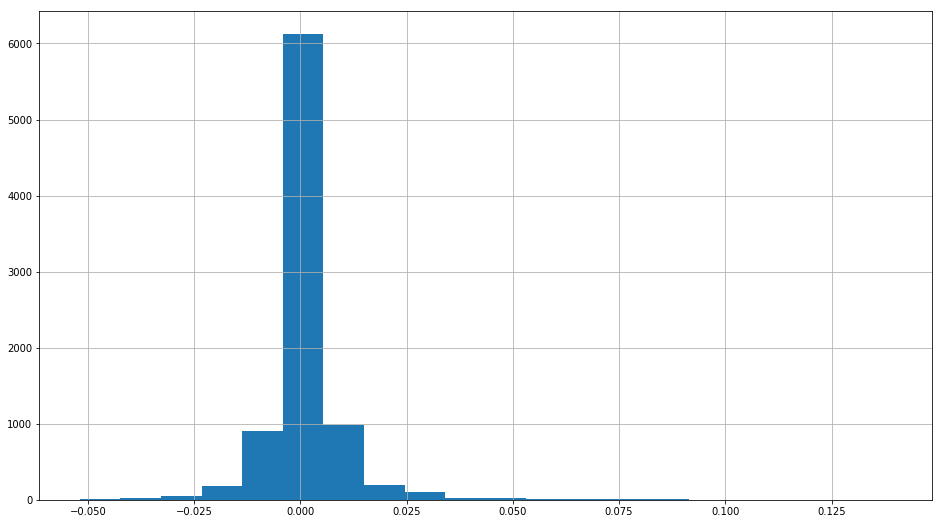

j=9 diff_pct_close_vs_ema_negative_unnormal: -0.027 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.139 diff_pct_close_vs_ema_positive_unnormal: 0.029


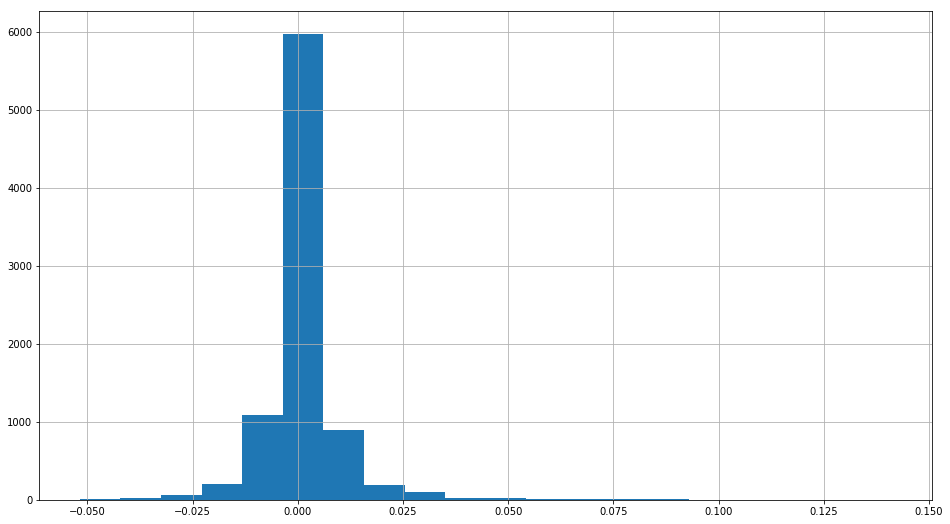

j=10 diff_pct_close_vs_ema_negative_unnormal: -0.028 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.141 diff_pct_close_vs_ema_positive_unnormal: 0.031


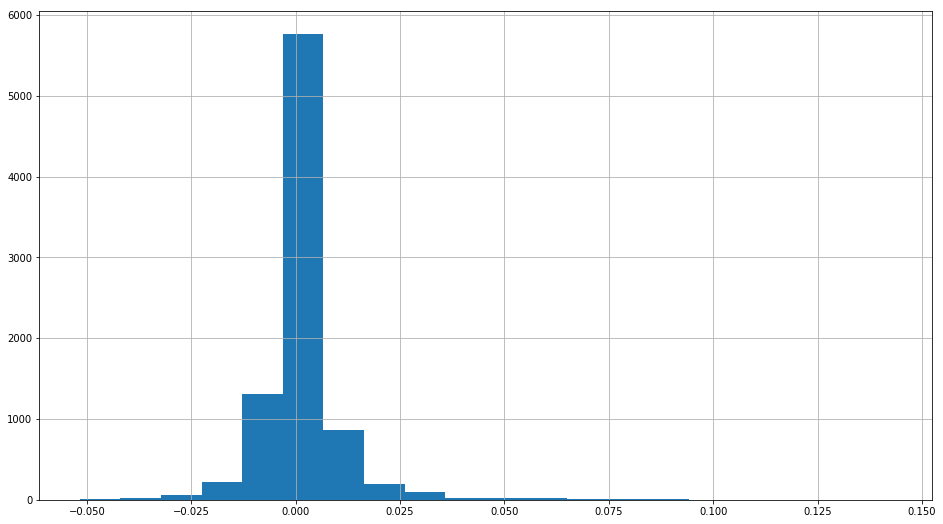

j=11 diff_pct_close_vs_ema_negative_unnormal: -0.029 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.143 diff_pct_close_vs_ema_positive_unnormal: 0.032


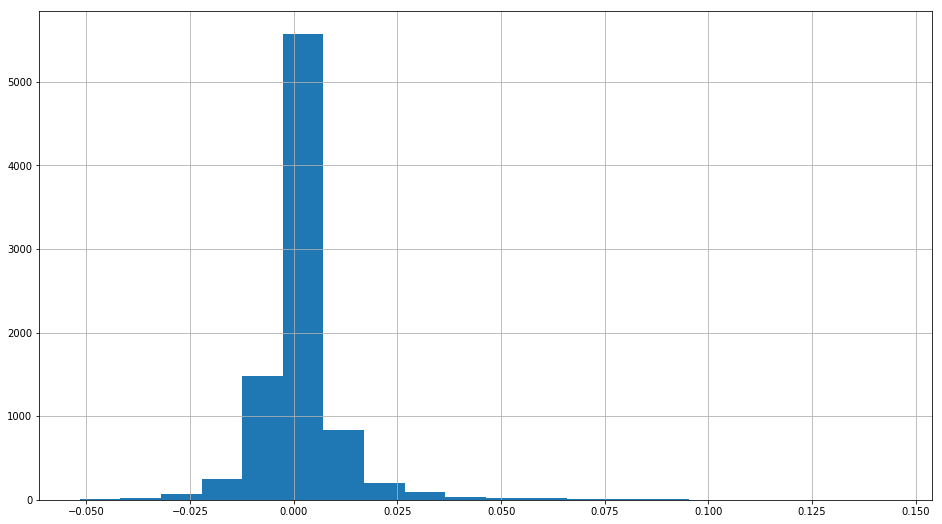

j=12 diff_pct_close_vs_ema_negative_unnormal: -0.030 diff_pct_close_vs_ema_min: -0.052 diff_pct_close_vs_ema_max:0.144 diff_pct_close_vs_ema_positive_unnormal: 0.034


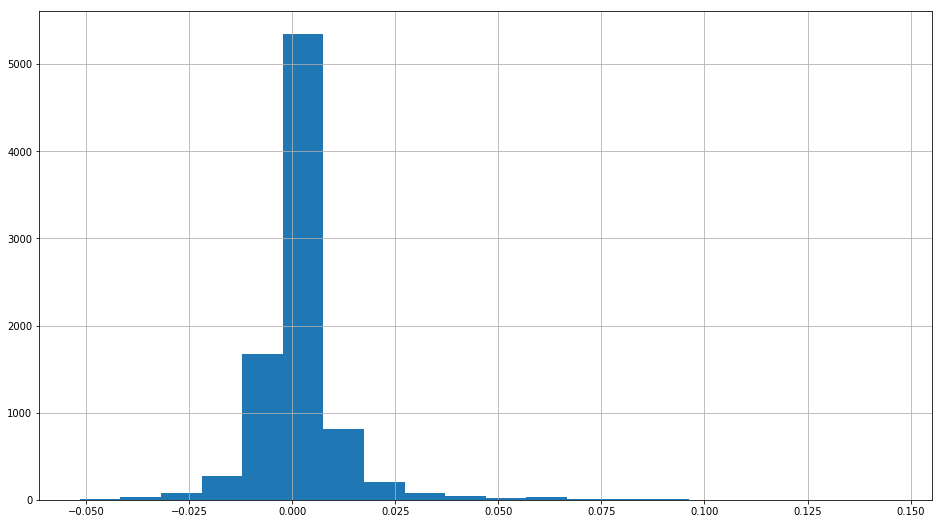

j=13 diff_pct_close_vs_ema_negative_unnormal: -0.031 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.145 diff_pct_close_vs_ema_positive_unnormal: 0.035


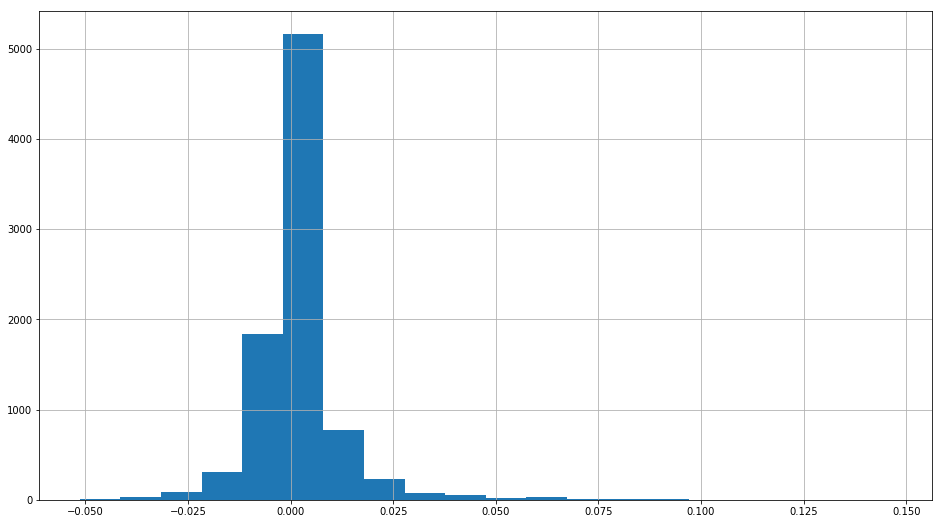

j=14 diff_pct_close_vs_ema_negative_unnormal: -0.032 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.146 diff_pct_close_vs_ema_positive_unnormal: 0.036


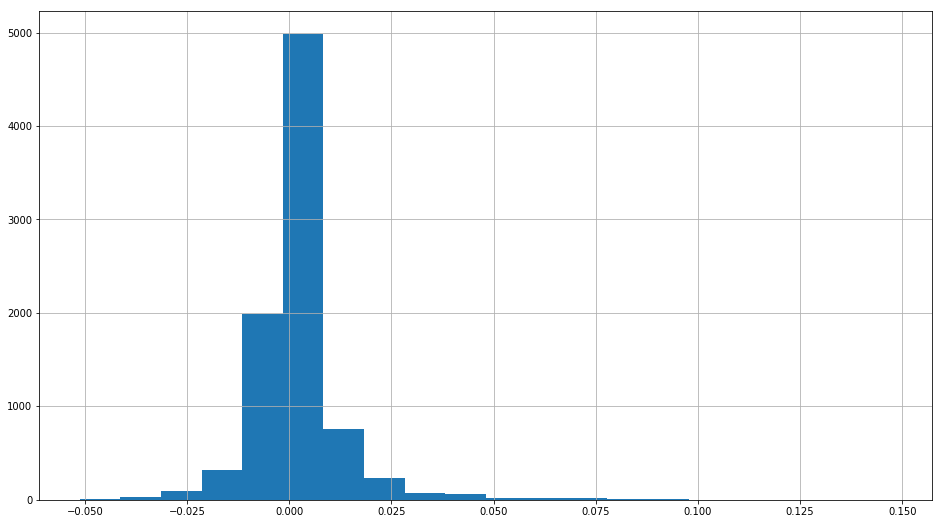

j=15 diff_pct_close_vs_ema_negative_unnormal: -0.033 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.147 diff_pct_close_vs_ema_positive_unnormal: 0.037


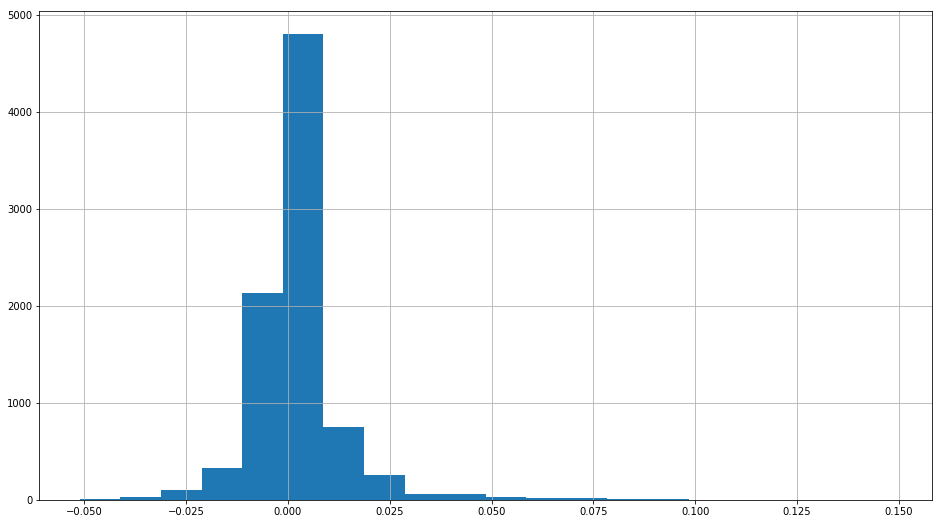

j=16 diff_pct_close_vs_ema_negative_unnormal: -0.034 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.148 diff_pct_close_vs_ema_positive_unnormal: 0.039


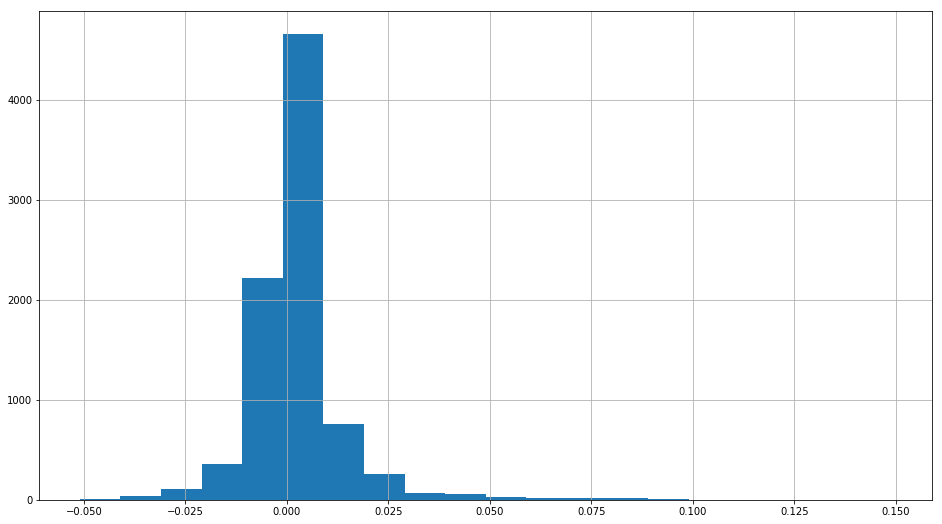

j=17 diff_pct_close_vs_ema_negative_unnormal: -0.035 diff_pct_close_vs_ema_min: -0.051 diff_pct_close_vs_ema_max:0.149 diff_pct_close_vs_ema_positive_unnormal: 0.040


In [18]:


diff_pct_close_vs_ema = []
diff_pct_close_vs_ema_mean = []
diff_pct_close_vs_ema_std = []
diff_pct_close_vs_ema_negative_unnormal = []
diff_pct_close_vs_ema_positive_unnormal = []
diff_pct_close_vs_ema_max = []
diff_pct_close_vs_ema_min = []
for j in range(18):
    diff_pct_close_vs_ema.append((MarketChart['close'] - ema[j])/ ema[j])
    diff_pct_close_vs_ema_mean.append(diff_pct_close_vs_ema[j].mean())
    diff_pct_close_vs_ema_std.append(diff_pct_close_vs_ema[j].std())
    diff_pct_close_vs_ema_negative_unnormal.append(diff_pct_close_vs_ema_mean[j] - 3 * diff_pct_close_vs_ema_std[j])
    diff_pct_close_vs_ema_positive_unnormal.append(diff_pct_close_vs_ema_mean[j] + 3 * diff_pct_close_vs_ema_std[j])
    diff_pct_close_vs_ema_max.append(diff_pct_close_vs_ema[j].max())
    diff_pct_close_vs_ema_min.append(diff_pct_close_vs_ema[j].min())
    diff_pct_close_vs_ema[j].hist(bins=20,figsize=(16,9))
    plt.show()
    print('j={0} diff_pct_close_vs_ema_negative_unnormal: {1:.3f} diff_pct_close_vs_ema_min: {2:.3f} diff_pct_close_vs_ema_max:{3:.3f} diff_pct_close_vs_ema_positive_unnormal: {4:.3f}'.format(j, diff_pct_close_vs_ema_negative_unnormal[j], diff_pct_close_vs_ema_min[j], diff_pct_close_vs_ema_max[j], diff_pct_close_vs_ema_positive_unnormal[j]))

### select j and span

In [321]:

performance = {'j':[], 'final_pnl':[], 'win_rate':[]}
sig_buy_list = []
sig_sell_list = []
signal_list = []
trade_price_list =[]
for j in range(18):
    ## setup signal
    sig_buy = ma.ceil(diff_pct_close_vs_ema_negative_unnormal[j] * 1000) / 1000
    sig_buy_list.append(sig_buy)
    sig_sell = ma.floor(diff_pct_close_vs_ema_positive_unnormal[j] * 1000) / 1000
    sig_sell_list.append(sig_sell)
    index_stock_price = 1
    n_stock_price = len(MarketChart)
    sig = np.zeros(n_stock_price, dtype = np.int)
   
    for index_stock_price in range(n_stock_price):
        if diff_pct_close_vs_ema[j][index_stock_price - 1] <  sig_buy:
            sig[index_stock_price] = 1
        elif diff_pct_close_vs_ema[j][index_stock_price - 1] >= sig_sell:
            sig[index_stock_price] = - 1
        else:
            if sig[index_stock_price - 1] == 1:
                sig[index_stock_price] = 1
            elif sig[index_stock_price - 1] == 0:
                sig[index_stock_price] = 0
            elif sig[index_stock_price - 1] == - 1:
                sig[index_stock_price] = - 1
    signal = pd.Series(sig, index = MarketChart.index)
    signal_list.append(signal)
    # now let's accumulate some P&L
    position = 0
    principle = 5 * MarketChart.iloc[0, 0]
    pnl = 0
    previous_signal = 0
    start_price = 0
    negative_pnl = 0
    positive_pnl = 0
    for index, row in MarketChart.iterrows():
        current_signal = signal.loc[index]
        if current_signal != previous_signal: # we need to do a trade
            # first check if we have an open position
            if position != 0: 
                # first we need to close the position and calculate P&L
                trade_price_list.append(row['open'] * (1 - trading_cost_pct / 100))
                current_pnl = position * (row['open'] * (1 - trading_cost_pct / 100) - start_price)
                if position < 0:
                    principle += current_pnl
                else:
                    principle = trade_size * row['open'] * (1 - trading_cost_pct / 100) 
                if current_pnl < 0:
                    negative_pnl += 1
                else:
                    positive_pnl += 1
                pnl += current_pnl
                
            # now open a new position
            trade_size = principle * (1 - trading_cost_pct / 100) / row['open'] 
            position = trade_size * current_signal # buy if signal is positive, sell if signal is negative
            start_price = row['open'] * (1+ trading_cost_pct / 100)
            trade_price_list.append(start_price)
            previous_signal = current_signal
    win_rate = positive_pnl / (positive_pnl + negative_pnl) * 100
    performance['j'].append(j) 
    performance['final_pnl'].append(pnl)
    performance['win_rate'].append(win_rate)
    

In [322]:
## select j=8 when final_pnl is the max
performance_df = pd.DataFrame(performance)
performance_df[performance_df['final_pnl'] == performance_df['final_pnl'].max()]

,j,final_pnl,win_rate
8,8,6161.337421,87.5
9,9,6161.337421,87.5


## calculate the annual return of EMA trade strategy

In [323]:
## calculate monthly retrun
monthly_return = performance_df.loc[8, 'final_pnl'] / principle 

## calculate annual return
annual_return = (monthly_return + 1) ** 12 - 1
annual_return

28.913845992914837

In [324]:
monthly_return

0.3273619206635282

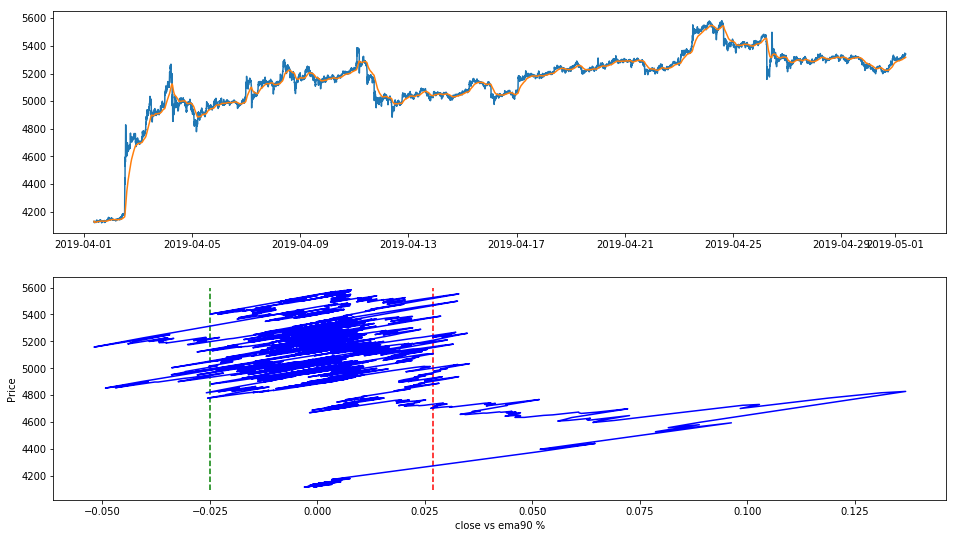

In [82]:
## 
register_matplotlib_converters()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,9), sharex=False)
ax1.plot(MarketChart.index, MarketChart['close'])
ax1.plot(MarketChart.index, ema[8])
ax2.plot(diff_pct_close_vs_ema[8], MarketChart['close'], "b-")
ax2.set_xlabel('close vs ema{0:d} %'.format(90))
ax2.set_ylabel('Price')
ax2.vlines(sig_buy_list[8], 4100, 5600, colors = "green", linestyles = "dashed")
ax2.vlines(sig_sell_list[8], 4100, 5600, colors = "red", linestyles = "dashed")

In [24]:
## select min period of trading
signal_s8 = pd.Series(signal_list[8])

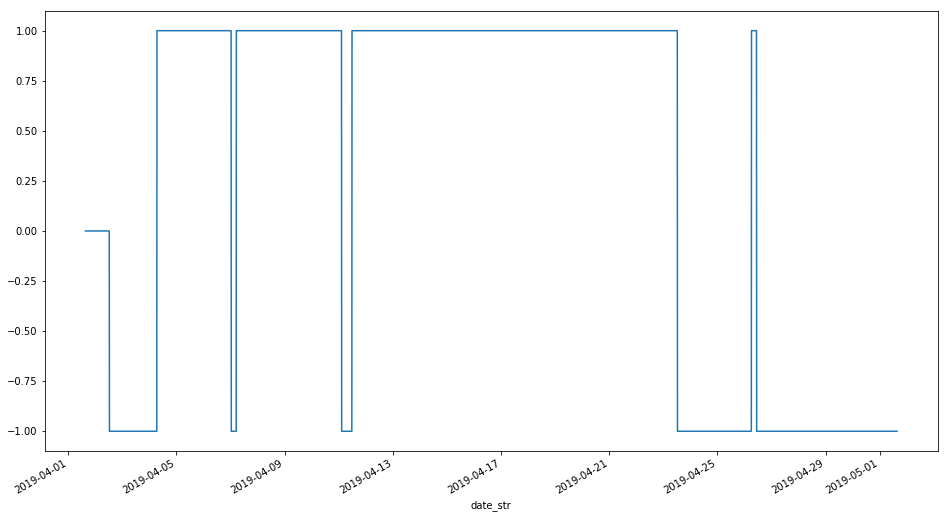

In [43]:
signal_s8.plot(figsize=(16,9))

In [47]:
## select trading period = 4 hours
signal_s8[signal_s8 == 1]['2019-04-26']

date_str
2019-04-26 06:05:00    1
2019-04-26 06:10:00    1
2019-04-26 06:15:00    1
2019-04-26 06:20:00    1
2019-04-26 06:25:00    1
2019-04-26 06:30:00    1
2019-04-26 06:35:00    1
2019-04-26 06:40:00    1
2019-04-26 06:45:00    1
2019-04-26 06:50:00    1
2019-04-26 06:55:00    1
2019-04-26 07:00:00    1
2019-04-26 07:05:00    1
2019-04-26 07:10:00    1
2019-04-26 07:15:00    1
2019-04-26 07:20:00    1
2019-04-26 07:25:00    1
2019-04-26 07:30:00    1
2019-04-26 07:35:00    1
2019-04-26 07:40:00    1
2019-04-26 07:45:00    1
2019-04-26 07:50:00    1
2019-04-26 07:55:00    1
2019-04-26 08:00:00    1
2019-04-26 08:05:00    1
2019-04-26 08:10:00    1
2019-04-26 08:15:00    1
2019-04-26 08:20:00    1
2019-04-26 08:25:00    1
2019-04-26 08:30:00    1
2019-04-26 08:35:00    1
2019-04-26 08:40:00    1
2019-04-26 08:45:00    1
2019-04-26 08:50:00    1
2019-04-26 08:55:00    1
2019-04-26 09:00:00    1
2019-04-26 09:05:00    1
2019-04-26 09:10:00    1
2019-04-26 09:15:00    1
2019-04-26 09:20